<a href="https://colab.research.google.com/github/sumadvena/SiOC_2023/blob/main/SiOC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zadania: zaobserwować aliasing i ogarniać prędkość odczytu


# Rolling Shutter

This exercise is a warmup exercise, which goal is to simulate rolling shutter effect of digital camera, when it is recording a fast-moving object.

The intruction is available [here](http://konrad.kluwak.staff.iiar.pwr.edu.pl/wp-content/uploads/2022/10/0-Aliasing2D.pdf).

Useful resources:
* [Smarter Every Day @ YouTube](https://www.youtube.com/watch?v=dNVtMmLlnoE)
* [CMOS @ Wikipedia](https://en.wikipedia.org/wiki/CMOS#:~:text=Complementary%20metal%E2%80%93oxide%E2%80%93semiconductor%20\(,type%20MOSFETs%20for%20logic%20functions.)
* [Animated Matplotlib](https://www.geeksforgeeks.org/create-an-animated-gif-using-python-matplotlib/)
* [Animated Matplotlib](https://matplotlib.org/2.1.2/gallery/animation/movie_demo_sgskip.html)

# Setup

In [2]:
import numpy as np
import seaborn as sns
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import distance_matrix
from skimage import io
from tqdm import tqdm as progress_bar

# Simulation

Setup constant values controlling the simulation

In [3]:
M = 64  # number of time-step in the simulated sequence
N = 3  # number of propeller wings

Simple function drawing propeller like curve

In [4]:
def propeller(theta, m):
    """Simulate a properller using simple function"""
    return np.sin(N*theta + m * np.pi / 10)  # should work for odd and even N

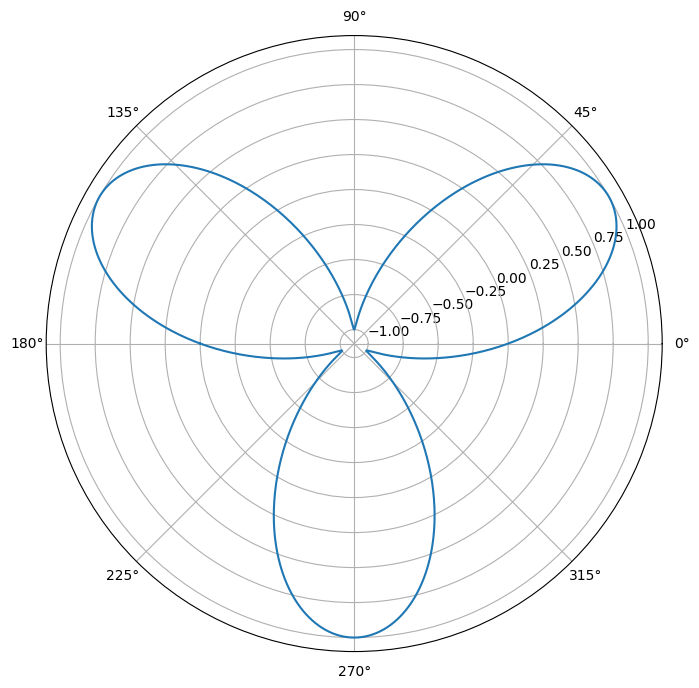

In [5]:
thetas = np.linspace(-np.pi, np.pi, 1000)  # linspace of angles to plot
r = propeller(thetas, m=0)

_ = plt.figure(figsize=[8, 8])
_ = plt.polar(thetas, r)  # assign to supress output print by IPython

### Create Animation

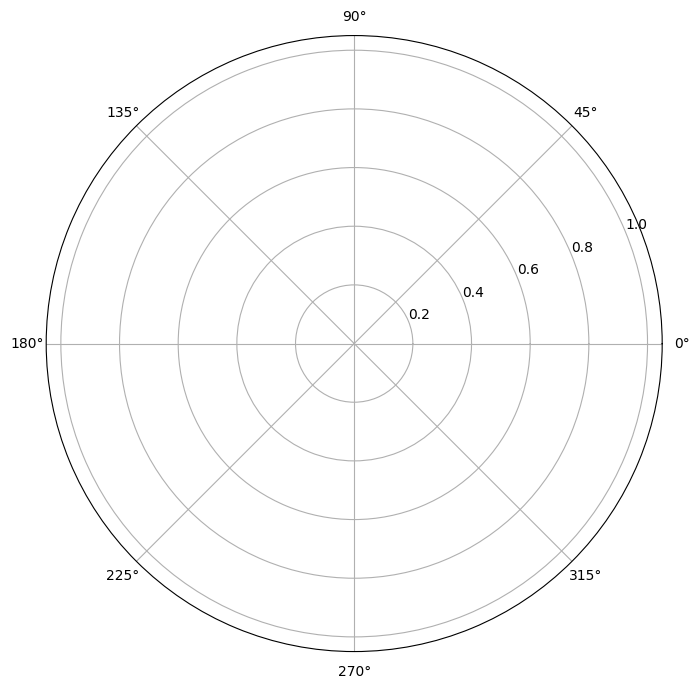

In [6]:
figure = plt.figure(figsize=[8, 8])
plot = plt.polar([])[0]  # empty polar figure

In [7]:
def animate(frame):
    propeller_curve = propeller(thetas, m=frame)
    plot.set_data((thetas, propeller_curve))

In [8]:
animation = FuncAnimation(figure, animate, frames=100, interval=25)

In [9]:
video = animation.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()

# Simulate Sensor

Simulate sensor looking at a static propeller curve.



In [10]:
thetas = np.linspace(-np.pi, np.pi, 1000)  # linspace of angles to plot
rs = propeller(thetas, m=0)

Two utility functions for capture simulation

In [11]:
def polar_to_cartesian(theta, r):
    """Convert polar coordinate arrays to cartesian"""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack([x, y])


def capture(func: np.array, resolution: int, threshold: float = 0.1, low: float = -1, high: float = 1) -> np.array:
    """
    Simulation of image capture by CMOS sensor of any mathematical function represented as array of 2D points

    :param func: array containing data-points of some mathematical curve of 2D pattern
    :param resolution: number of pixels of square grid
    :param threshold: distance threshold for image capture
    :param low: lower border of the sensor grid
    :param high: upper border of the sensor grid
    """
    grid_x, grid_y = np.meshgrid(np.linspace(low, high, resolution), np.linspace(low, high, resolution))
    grid = np.column_stack([grid_x.flatten(), grid_y.flatten()])

    distances = distance_matrix(grid, func)
    capture = (np.min(distances, axis=1) <= threshold).astype(int).reshape(resolution, resolution)

    return capture

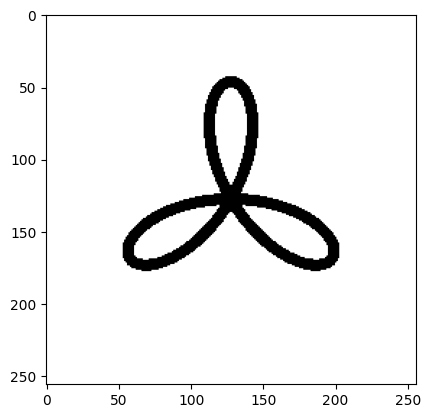

In [12]:
_ = plt.imshow(capture(polar_to_cartesian(thetas, rs), resolution=256, threshold=0.05, low=-np.pi / 2, high=np.pi / 2), cmap="Greys")

# Moving Propeller

In [13]:
thetas = np.linspace(-np.pi, np.pi, 1000)  # linspace of angles to plot
ms = np.arange(-M // 2, M // 2)  # sequence of phase offsets to simulate movement

Pre-compute values of func with different values of `m` parameter, which is the angle by which propeller is rotated in each frame.

In [14]:
funcs = []

for m in ms.tolist():
    r = propeller(thetas, m=m)
    func = polar_to_cartesian(thetas, r)
    funcs.append(func)

funcs = np.asarray(funcs)

In [15]:
def record(funcs: list, capture_kwargs) -> np.array:
    """Simulate recording by applying capture in loop"""
    return np.asarray([capture(func, **capture_kwargs) for func in progress_bar(funcs)])

Compute records, estimated time per-frame is around 4 seconds.

In [ ]:
recording = record(funcs, capture_kwargs=dict(resolution=256, threshold=0.05, low=-np.pi / 2, high=np.pi / 2))
recording.shape

 34%|███▍      | 22/64 [01:25<02:32,  3.63s/it]

It is possible to experiment with values to observe different rolling shutter effects.

In [ ]:
offset = 0
length = 4  # number of lines CMOS reads per frame
capture = np.zeros([256, 256])  # initialize empty image

for frame in recording:
    capture[offset : offset + length, :] = frame[offset : offset + length, :]
    offset += length

In [ ]:
plt.imshow(capture, cmap="Greys")